In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
distributions = [ #['nominal', 30445, 'ding'], #name, fr run, root file
                  #['half_high', 30464, 'ding'],
                  #['half_low', 30466, 'ding'],
                  #['third_high', 30468, 'ding'],
                  #['third_low', 30472, 'ding'],
                  ['fifth_high', 30475, 'results_fifthCtag_highMomentum.root'],
                  ['fifth_low', 30479, 'results_fifthCtag_lowMomentum.root']
                  #['fifth_middle', 30483, 'ding']
                ]

nDists = len(distributions)

### Fast rotation distributions
---

In [3]:
frdists = []
for name, run, hist_file in distributions:
    f = r.TFile("./fastRotation/CornellFourier_run"+str(run)+"_results.root")
    #f.ls()
    gri = f.Get("rad")
    frdists.append(gri.Clone("rad_"+str(name)))
print(frdists)
    

[<ROOT.TGraph object ("rad_fifth_high") at 0x7ffff95511b0>, <ROOT.TGraph object ("rad_fifth_low") at 0x7ffff93a3f30>]


In [4]:
colors = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

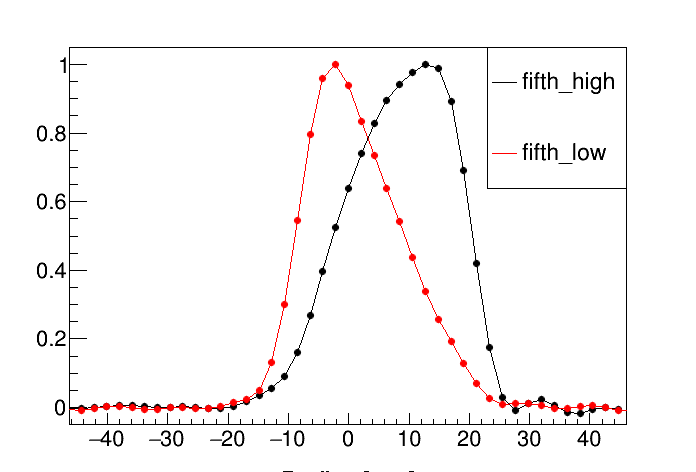

In [5]:
c = r.TCanvas()
leg = r.TLegend(0.7,0.6,0.9,0.9)

for i in range(nDists):
    if(i > 0):
        frdists[i].Draw("pl SAME")
    else:
        frdists[i].Draw("apl")
    frdists[i].SetLineColor(colors[i])
    frdists[i].SetMarkerColor(colors[i])
    leg.AddEntry(frdists[i], distributions[i][0],"l")
leg.Draw("SAME")
c.Draw()

---
### Now lets get the muon loss functions
---

In [27]:
lossHistograms = []

for name, run, hist_file in distributions:
    f = r.TFile("./muonLoss/"+hist_file)
    #f.ls()
    
    h_sing = f.Get("CoincidenceFinderLM/clusterTimecaloNumsingle_").Clone("h_sing")
    h_sing.SetDirectory(0)
    h_tripi = f.Get("CoincidenceFinderLM/clusterTimecaloNumtriple_").Clone("h_tripi")
    h_tripi.SetDirectory(0)
    
    h_trip = r.TH3D()
    h_tripi.Copy(h_trip)
    h_trip.SetDirectory(0)
    
    #print(h_sing.GetEntries(), h_sing.Integral())
    #print(h_tripi.GetEntries(), h_tripi.Integral())
    #print(h_trip.GetEntries(), h_trip.Integral())
    
    ctag =  h_sing.Project3D("y").Integral(h_sing.GetYaxis().FindBin(24000), -1)
    #print(ctag)
    f.Close()

    h_trip.Scale(1/ctag)
    print(h_sing, h_trip)
    
    h_trip_y = h_trip.Project3D("y").Clone("h_trip_y")
    h_trip_y.SetDirectory(0)
    
    lossHistograms.append( h_trip_y.Clone("h_trip_y_"+str(name)) )
    
print(lossHistograms)

<ROOT.TH3I object ("h_sing") at 0x7ffffa259bf0> <ROOT.TH3D object ("h_tripi") at 0x7ffff954fe60>
<ROOT.TH3I object ("h_sing") at 0x7ffffa24d080> <ROOT.TH3D object ("h_tripi") at 0x7ffffa2564b0>
[<ROOT.TH1D object ("h_trip_y_fifth_high") at 0x7ffffa2534b0>, <ROOT.TH1D object ("h_trip_y_fifth_low") at 0x7ffffa47e0e0>]


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


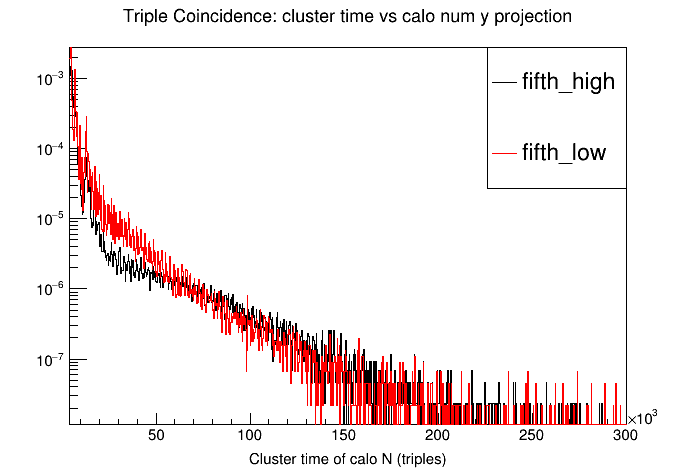

In [28]:
c = r.TCanvas()
leg = r.TLegend(0.7,0.6,0.9,0.9)

for i in range(nDists):
    if(i > 0):
        lossHistograms[i].Draw("hist SAME")
    else:
        lossHistograms[i].Draw("hist")
        #lossHistograms[i].GetYaxis().SetRangeUser(0.000000000001,1)
    lossHistograms[i].SetLineColor(colors[i])
    lossHistograms[i].SetMarkerColor(colors[i])
    leg.AddEntry(lossHistograms[i], distributions[i][0],"l")
leg.Draw("SAME")
c.SetLogy()
c.Draw()

---

### Ok, so now we have the distributions. Lets get to generating some random numbers

---

In [ ]:
positionBounds = [-20,40] #mm
timeBounds = [0,300] #mus
positionBins = 100
timeBins = 100

h = r.TH2D("h","Position in FR Distribution vs. Time for Decays",
           positionBins, positionBounds[0], positionBounds[1],
           timeBins, timeBounds[0], timeBounds[1]
           )
np.random.seed(1234)
verbosity = 0
nMuons = 100000
checkWhetherLost = True


for i in range(nMuons):
    #generate a random x,t pair
    if(verbosity > 0):
        print("***************************************")
    x = np.random.uniform(positionBounds[0], positionBounds[1])
    t = np.random.uniform(timeBounds[0], timeBounds[1])
    #get the probability of being in each FR distribution from the functions in funcs
    absoluteProbs = []
    for f in frdists:
        value = f.Eval(x)
        if( value > 0):
            absoluteProbs.append( f.Eval(x) )
        else:
            absoluteProbs.append(0)
    #normalize the probablitites at this point, and choose one
    if(verbosity > 0):
        print(absoluteProbs)
    if(sum(absoluteProbs) <= 0.0):
        continue
    normProbs = [float(i)/sum(absoluteProbs) for i in absoluteProbs]
    if(verbosity > 0):
        print(normProbs)
    choice = np.random.choice(len(normProbs),1,p=normProbs)[0]

    #get the probability of being lost from this distribution at this time
    #pLoss = lossHistograms[choice].Interpolate(t)
    pLoss = frdists[choice].Eval(x)
    overUnder = np.random.random()
    if(verbosity > 0):
        print(x)
        print(normProbs)
        print(choice)
        print(pLoss, overUnder)

    if((pLoss > overUnder) or  not checkWhetherLost):
        h.Fill(x,t)
        #print("hi")

In [ ]:
c = r.TCanvas()
h.Draw("colz")
c.Draw()

In [ ]:
c = r.TCanvas("c","c",1800,600)
c.Divide(2)
c.cd(1)
h.ProjectionX().Draw()
c.cd(2)
h.ProjectionY().Draw()
c.Draw()